In [207]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from ultralytics import SAM
import os
import glob


In [276]:
# Usage
scan_dir = "merged_scan_2"
image_dir = "355_perspective"


anomaly_mask = np.load(f"results/anomaly_masks/exp_train400_coreset0.3/{scan_dir}_{image_dir}_mask.npy")
original_image_path = f"masonry_dataset/wall/test/defect/{scan_dir}_{image_dir}.png"
original_point_path = f"bucket/analysis-pipeline-data/National_Highways/Wheatley_Tunnel/data_intermediate/figures/dataset_depth_image/20250617/{scan_dir}/{image_dir}.npz"
original_image = cv2.imread(original_image_path)


In [265]:
points = np.load(original_point_path)
print(points.files)

points = points['xyz']
print(points.shape)


['xyz', 'p_center', 'normal', 'x_axis', 'img_size', 'focal_length', 'point_size', 'depth_map_interp', 'depth_img_interp', 'R_wtc', 'T_wtc', 'R_ctw', 'T_ctw', 'xy_camera', 'z_camera']
(341915, 3)


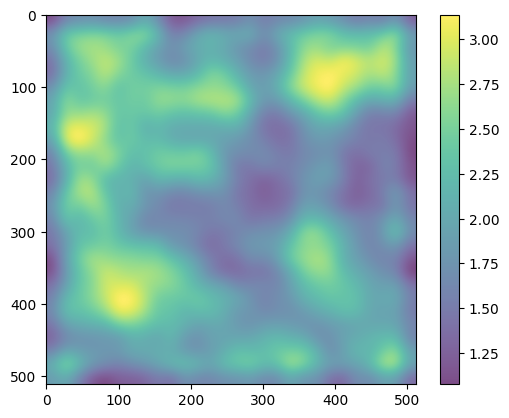

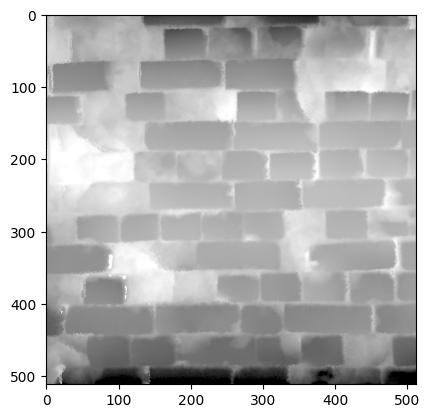

In [277]:
plt.imshow(anomaly_mask, alpha=0.7)
plt.colorbar()
plt.show()

# Show contour lines at different anomaly score levels
plt.imshow(original_image)  # Your background image
plt.show()


In [237]:
import numpy as np
from matplotlib.path import Path

def get_contour_centroids(contours, image_shape):
    """
    Get center of mass (centroid) for each contour - simple and fast

    Args:
        contours: matplotlib contour object from plt.contour()
        image_shape: (height, width) of the original image

    Returns:
        np.array: Array of [x, y] coordinates of centroids
    """
    centroids = []

    for level_idx in range(len(contours.levels)):
        level_paths = contours.collections[level_idx].get_paths()

        for path in level_paths:
            if len(path.vertices) < 3:
                continue

            vertices = path.vertices

            # Get bounding box
            x_min, y_min = np.floor(vertices.min(axis=0)).astype(int)
            x_max, y_max = np.ceil(vertices.max(axis=0)).astype(int)

            # Clamp to image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image_shape[1], x_max)
            y_max = min(image_shape[0], y_max)

            if x_max <= x_min or y_max <= y_min:
                continue

            # Create all points in bounding box
            xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
            points = np.column_stack([xx.ravel(), yy.ravel()])

            # Find points inside contour
            path_obj = Path(vertices)
            inside_mask = path_obj.contains_points(points)
            inside_points = points[inside_mask]

            if len(inside_points) > 0:
                # Simple center of mass - just mean of all points
                centroid_x = np.mean(inside_points[:, 0])
                centroid_y = np.mean(inside_points[:, 1])
                centroids.append([centroid_x, centroid_y])

    return np.array(centroids)


In [238]:
def expand_centroids(centroids, anomaly_mask, margin=20):
    """
    Add corner points around each centroid while keeping the original
    """
    all_points = []

    for centroid in centroids:
        x, y = centroid

        # Clamp to image boundaries
        x_min = max(x - margin, 0)
        x_max = min(x + margin, anomaly_mask.shape[1] - 1)
        y_min = max(y - margin, 0)
        y_max = min(y + margin, anomaly_mask.shape[0] - 1)

        # Original centroid + 4 corners
        points = [
            [x, y],           # Original centroid
            [x_min, y_min],   # Top-left
            [x_max, y_min],   # Top-right
            [x_min, y_max],   # Bottom-left
            [x_max, y_max]    # Bottom-right
        ]

        all_points.extend(points)

    return np.array(all_points)



In [280]:
def get_contour_bounding_boxes(contours, padding=10):
    """
    Extract bounding boxes from matplotlib contours for SAM prompts

    Args:
        contours: matplotlib contour object from plt.contour()
        padding: pixels to add around each bounding box

    Returns:
        list: List of bounding boxes in [x1, y1, x2, y2] format for SAM
    """
    bounding_boxes = []

    for level_idx in range(len(contours.levels)):
        level_paths = contours.collections[level_idx].get_paths()

        for path in level_paths:
            if len(path.vertices) < 3:
                continue

            vertices = path.vertices

            # Get min/max coordinates
            x_min = vertices[:, 0].min()
            x_max = vertices[:, 0].max()
            y_min = vertices[:, 1].min()
            y_max = vertices[:, 1].max()

            # Add padding
            x1 = max(0, int(x_min - padding))
            y1 = max(0, int(y_min - padding))
            x2 = int(x_max + padding)
            y2 = int(y_max + padding)

            # SAM format: [x1, y1, x2, y2]
            bbox = [x1, y1, x2, y2]
            bounding_boxes.append(bbox)

    return bounding_boxes

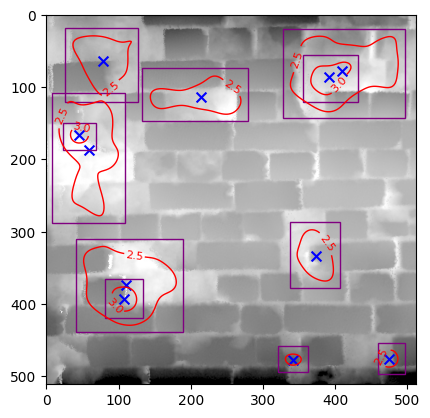

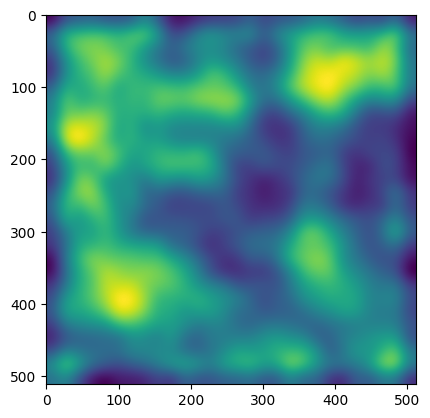

In [287]:
import numpy as np
import cv2
from matplotlib.path import Path

# Usage with your existing contours
contours = plt.contour(anomaly_mask, levels=[2.5, 3.0, 3.5], colors='red', linewidths=1)

centroids = get_contour_centroids(contours, anomaly_mask.shape)

#centroids = expand_centroids(centroids, anomaly_mask)

# Visualize
plt.imshow(original_image)
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='blue', s=50, marker='x')
plt.clabel(contours, inline=True, fontsize=8)  # Add labels showing the levels

bounding_boxes = get_contour_bounding_boxes(contours)
for i, bbox in enumerate(bounding_boxes):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height,
                        fill=False, color='purple', linewidth=1)
    plt.gca().add_patch(rect)

plt.show()

plt.imshow(anomaly_mask)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()



In [193]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

sam_model = SAM('sam2_l.pt')


0: 512x512 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 68.5ms
Speed: 1.5ms preprocess, 68.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict21


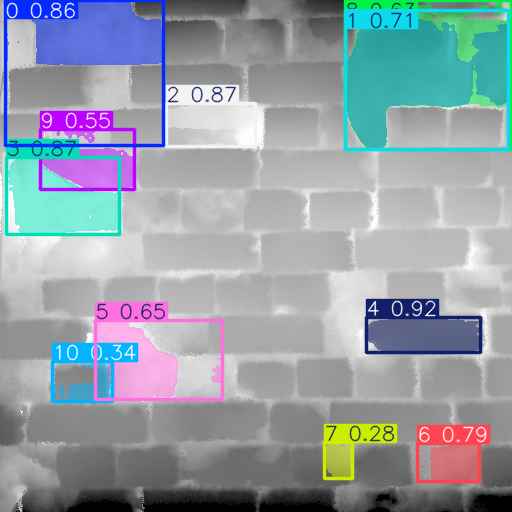

In [279]:
def run_sam_on_hotspots(image_path, maxima_points):
    """Simple function to run SAM on hotspot points"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert points to numpy array
    points = np.array(maxima_points)

    labels = np.ones(len(maxima_points))


    # Run SAM
    results = sam_model(image_rgb, points=points, labels=labels, imgsz=512, save=True)

    return image_rgb, results

_, results = run_sam_on_hotspots(original_image_path, centroids)
results[0].show()


0: 512x512 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 67.4ms
Speed: 1.6ms preprocess, 67.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict21


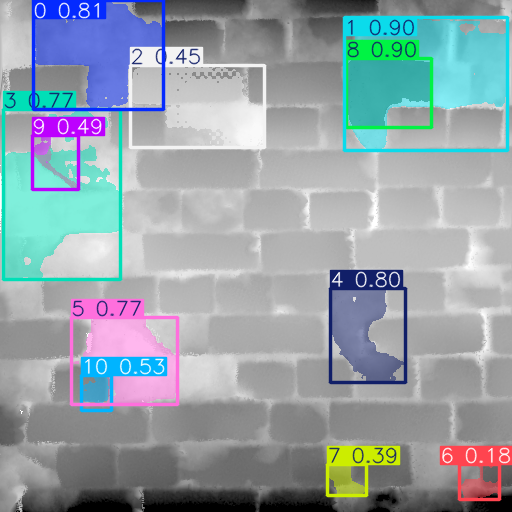

In [290]:
def run_sam_on_bboxes(image_path, bboxes):
    """Simple function to run SAM on hotspot points"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert points to numpy array
    points = np.array(bboxes)

    labels = np.ones(len(bboxes))


    # Run SAM
    results = sam_model(image_rgb, bboxes=bboxes, labels=labels, imgsz=512, save=True)

    return image_rgb, results

_, results = run_sam_on_bboxes(original_image_path, bounding_boxes)
results[0].show()
